In [1]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
class SizeAdjuster:
    def __init__(self, standard_height, standard_width):
        self.standard_height = standard_height
        self.standard_width = standard_width
        self.standard_aspect_ratio = standard_width / standard_height
        
    def zoom_adjust(self, img, axis):
        # 縮放調整圖片的副程式：等比例將圖片寬、高其中一邊調成標準大小
        # [參數] img:原始圖片，型態為ndarray ,  axis:用來選擇做為基準的邊(軸)
        #     axis == 0 將img.shpae[0]，即圖片的高調整成 standard_height
        #     axis == 1 將img.shpae[1]，即圖片的寬調整成 standard_width
        #     axis 若為 0,1以外的值就直接將圖片resize成標準尺寸
        if axis == 0:
            zoom_ratio = self.standard_height / img.shape[0]
            img = cv2.resize(img, (int(img.shape[1]*zoom_ratio), self.standard_height))
        elif axis == 1:
            zoom_ratio = self.standard_width / img.shape[1]
            img = cv2.resize(img, (self.standard_width, int(img.shape[0]*zoom_ratio)))
        else:
            img = cv2.resize(img, (self.standard_width, self.standard_height))
        return img
    
    def padding(self, img, axis):
        # 將調整過的圖片擴展成標準size(針對不足的區塊全部填充 0)
        # [參數] img:調整後的圖片，型態為ndarray ,  axis:小於標準寬高的軸(短邊)
        # 先創建一個標準size的空圖片 A，再將img複製到 A的中間
        A = np.zeros((self.standard_height, self.standard_width, 3), dtype=np.uint8)
        if axis == 0:
            bottom = int((self.standard_height - img.shape[0]) / 2)
            top = bottom + img.shape[0]
            A[bottom:top,:,:] = img
        elif axis == 1:
            left = int((self.standard_width - img.shape[1]) / 2)
            right = left + img.shape[1]
            A[:,left:right,:] = img
        return A
        
    def cropping(self, img, axis):
        # 等比例將圖片寬、高中較短的邊調成標準大小，再切除長邊多餘的部分
        # [參數] img:原始圖片，型態為ndarray ,  axis:用來選擇作為基準的軸(短邊)
        img = self.zoom_adjust(img, axis)
        if axis == 0:
            left = int((img.shape[1] - self.standard_width) / 2)
            right = left + self.standard_width
            img = img[:,left:right,:]
        elif axis == 1:
            bottom = int((img.shape[0] - self.standard_height) / 2)
            top = bottom + self.standard_height
            img = img[bottom:top,:,:]
        return img
    
    def size_adjust(self, img, method="warping"):
        # 將圖片調整成標準size，有三種方法，預設為resize
        #     method == "warping": 直接透過cv2模組resize成標準尺寸
        #     method == "padding": 將圖片等比縮放至長邊等於標準大小，再填滿剩餘區域
        #     method == "cropping": 將圖片等比縮放至短邊等於標準大小，再將多餘區域切除
        if img.shape[2] > 3:
            img = img[:,:,0:3]
        if method == "warping":
            img = self.zoom_adjust(img, 2)
        elif method == "padding":
            aspect_ratio = img.shape[1] / img.shape[0]
            if aspect_ratio < self.standard_aspect_ratio:
                img = self.zoom_adjust(img, 0)
                img = self.padding(img, 1)
            elif aspect_ratio > self.standard_aspect_ratio:
                img = self.zoom_adjust(img, 1)
                img = self.padding(img, 0)
            else:
                img = self.zoom_adjust(img, 2)
        elif method == "cropping":
            aspect_ratio = img.shape[1] / img.shape[0]
            if aspect_ratio < self.standard_aspect_ratio:
                img = self.cropping(img, 1)
            elif aspect_ratio > self.standard_aspect_ratio:
                img = self.cropping(img, 0)
            else:
                img = self.zoom_adjust(img, 2)
        else:
            print("Error: Argument 'method' not allowed")
        return img
    
    def batch_adjust(self, img_list, method="warping"):
        # 將一組存在list中的圖片都調整成標準size
        X = []
        for i in range(len(img_list)):
            X.append(self.size_adjust(img_list[i], method))
        return X
            

In [5]:
def import_image(PATH, test_data=False, Randomness=False):
    # 將PATH路徑下所有子資料夾的圖片讀入，並以其所在資料夾名稱做 Label
    # 若test_data值為True，自動將資料分成訓練集與測試集兩部分回傳
    X_train = [];  X_test = [];  y_train = [];  y_test = [];
    train_test_dist = [];  i = 0;  j = 0;
    
    def recursive_loading(PATH, kind, i):
        for file in os.listdir(PATH):
            if (not "." in file):
                i = recursive_loading(PATH + '/' + file, file, i)
            elif (".jpg" in file):
                img = mpimg.imread(PATH + '/' + file)
                X_train.append(img)
                y_train.append(kind)
                i = i + 1
                if i % 50 == 0:
                    print("Loading:", i)
        return i
    
    def training_testing_loading(PATH, kind, i, j):
        for file in os.listdir(PATH):
            if (not "." in file):
                i, j = training_testing_loading(PATH + '/' + file, file, i, j)
            elif (".jpg" in file):
                img = mpimg.imread(PATH + '/' + file)
                temp = random.random()
                if temp < 0.7:
                    X_train.append(img)
                    y_train.append(kind)
                    i = i + 1
                else:
                    X_test.append(img)
                    y_test.append(kind)
                    j = j + 1
                if (i+j) % 50 == 0:
                    print("Loading:", i+j)
        return i, j
    
    n = len(PATH)
    if PATH[n-1] == '/':
        PATH = PATH[ :n-1]
    if test_data:
        if Randomness == False:
            random.seed(100)
        i, j = training_testing_loading(PATH, "undefinied", i, j)
        print("Complete, total:", i+j)
        print("training data:", i, " testing data:", j)
        return (X_train, y_train, X_test, y_test)
    else:
        i = recursive_loading(PATH, "undefinied", i)
        print("Complete, total:", i)
        return (X_train, y_train)

In [6]:
# 設定圖片的標準尺寸和存放的路徑
standard_height = 100; standard_width = 100
PATH = "C:/Users/Mr-Fish/Desktop/FIDS30/"

X_train, y_train, X_test, y_test = import_image(PATH, test_data=True)
SizeAdj = SizeAdjuster(standard_height, standard_width)

Loading: 32
Loading: 65
Loading: 103
Loading: 141
Loading: 173
Loading: 209
Loading: 241
Loading: 276
Loading: 314
Loading: 346
Loading: 378
Loading: 413
Loading: 446
Loading: 479
Loading: 516
Loading: 552
Loading: 588
Loading: 619
Loading: 659
Complete, total: 971
training data: 673  testing data: 298


In [45]:
X = SizeAdj.batch_adjust(original, "padding")

In [47]:
original[200].shape

(337, 450, 3)

In [46]:
X[200].shape

(100, 100, 3)

(-0.5, 99.5, 99.5, -0.5)

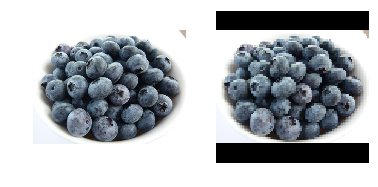

In [48]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(original[200])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(X[200])
plt.axis('off')

In [15]:
original = []
Apple1 = []
Apple2 = []
Apple3 = []
for file in os.listdir(PATH):
    img = mpimg.imread(PATH + file)
    original.append(img)
    Apple1.append(SizeAdj.size_adjust(img, method="warping"))
    Apple2.append(SizeAdj.size_adjust(img, method="padding"))
    Apple3.append(SizeAdj.size_adjust(img, method="cropping"))

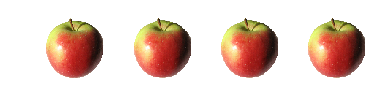

(1800, 1800, 3) (100, 100, 3) (100, 100, 3) (100, 100, 3)


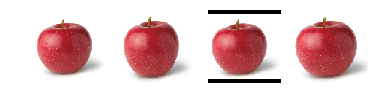

(300, 333, 3) (100, 100, 3) (100, 100, 3) (100, 100, 3)


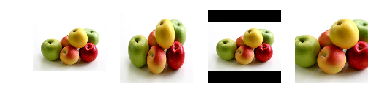

(253, 380, 3) (100, 100, 3) (100, 100, 3) (100, 100, 3)


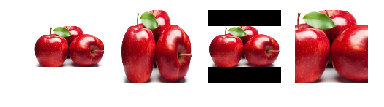

(534, 950, 3) (100, 100, 3) (100, 100, 3) (100, 100, 3)


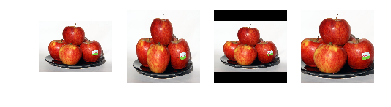

(2412, 3436, 3) (100, 100, 3) (100, 100, 3) (100, 100, 3)


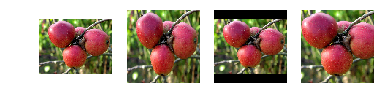

(1200, 1600, 3) (100, 100, 3) (100, 100, 3) (100, 100, 3)


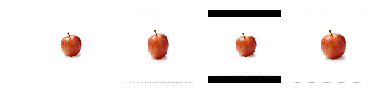

(314, 384, 4) (100, 100, 3) (100, 100, 3) (100, 100, 3)


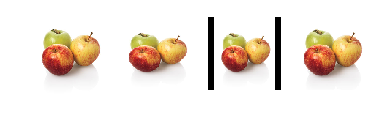

(357, 300, 3) (100, 100, 3) (100, 100, 3) (100, 100, 3)


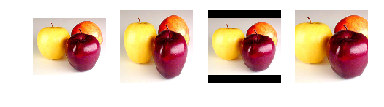

(275, 350, 3) (100, 100, 3) (100, 100, 3) (100, 100, 3)


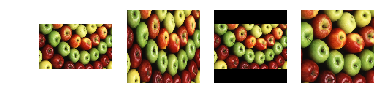

(1600, 2560, 3) (100, 100, 3) (100, 100, 3) (100, 100, 3)


In [16]:
for i in range(20,30):
    plt.figure()
    plt.subplot(1,4,1)
    plt.imshow(original[i])
    plt.axis('off')
    plt.subplot(1,4,2)
    plt.imshow(Apple1[i])
    plt.axis('off')
    plt.subplot(1,4,3)
    plt.imshow(Apple2[i])
    plt.axis('off')
    plt.subplot(1,4,4)
    plt.imshow(Apple3[i])
    plt.axis('off')
    plt.show()
    print(original[i].shape, Apple1[i].shape, Apple2[i].shape, Apple3[i].shape)

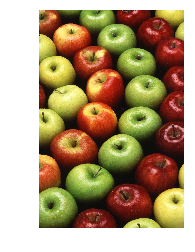

(2700, 1800, 3)


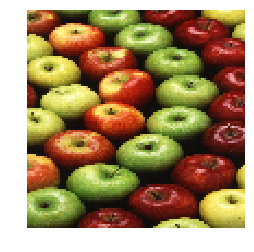

(100, 100, 3)


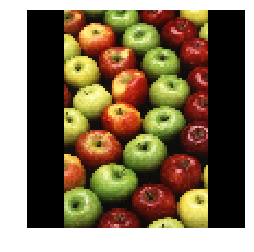

(100, 100, 3)


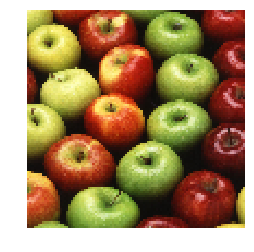

(100, 100, 3)


In [17]:
plt.imshow(original[0])
plt.axis('off')
plt.show()
print(original[0].shape)

plt.imshow(Apple1[0])
plt.axis('off')
plt.show()
print(Apple1[0].shape)

plt.imshow(Apple2[0])
plt.axis('off')
plt.show()
print(Apple2[0].shape)

plt.imshow(Apple3[0])
plt.axis('off')
plt.show()
print(Apple3[0].shape)

In [16]:
def zoom_adjust(img, axis):
    # 縮放調整圖片的副程式：等比例將圖片寬、高其中一邊調成標準大小
    # [參數] img:原始圖片，型態為ndarray ,  axis:用來選擇做為基準的邊(軸)
    #     axis == 0 將img.shpae[0]，即圖片的高調整成 standard_height
    #     axis == 1 將img.shpae[1]，即圖片的寬調整成 standard_width
    #     axis 若為 0,1以外的值就直接將圖片resize成標準尺寸
    if axis == 0:
        zoom_ratio = standard_height / img.shape[0]
        img = cv2.resize(img, (int(img.shape[1]*zoom_ratio),standard_height))
    elif axis == 1:
        zoom_ratio = standard_width / img.shape[1]
        img = cv2.resize(img, (standard_width,int(img.shape[0]*zoom_ratio)))
    else:
        img = cv2.resize(img, (standard_width,standard_height))
    img = img[:,:,0:3]
    return img

In [16]:
def padding(img, axis):
    # 將調整過的圖片擴展成標準size(針對不足的區塊全部填充 0)
    # [參數] img:調整後的圖片，型態為ndarray ,  axis:小於標準寬高的邊(軸)
    # 先創建一個標準size的空圖片 A，再將img複製到 A的中間
    A = np.zeros((standard_height,standard_width,3), dtype=np.uint8)
    if axis == 0:
        bottom = int((standard_height - img.shape[0]) / 2)
        top = bottom + img.shape[0]
        A[bottom:top,:,:] = img
    elif axis == 1:
        left = int((standard_width - img.shape[1]) / 2)
        right = left + img.shape[1]
        A[:,left:right,:] = img
    return A

In [18]:
def cropping(img, axis):
    # 等比例將圖片寬、高中較短的邊調成標準大小，再切除長邊多餘的部分
    # [參數] img:原始圖片，型態為ndarray ,  axis:用來選擇作為基準的軸(短邊)
    img = zoom_adjust(img, axis)
    if axis == 0:
        left = int((img.shape[1] - standard_width) / 2)
        right = left + standard_width
        img = img[:,left:right,:]
    elif axis == 1:
        bottom = int((img.shape[0] - standard_height) / 2)
        top = bottom + standard_height
        img = img[bottom:top,:,:]
    return img

In [19]:
def size_adjust(img, method="resize"):
    # 將圖片調整成標準size，有三種方法，預設為resize
    #     method == "warping": 直接透過cv2模組resize成標準尺寸
    #     method == "padding": 將圖片等比縮放至長邊等於標準大小，再填滿剩餘區域
    #     method == "cropping": 將圖片等比縮放至短邊等於標準大小，再將多餘區域切除
    if method == "warping":
        img = zoom_adjust(img, 2)
    elif method == "padding":
        aspect_ratio = img.shape[1] / img.shape[0]
        if aspect_ratio < standard_aspect_ratio:
            img = zoom_adjust(img, 0)
            img = padding(img, 1)
        elif aspect_ratio > standard_aspect_ratio:
            img = zoom_adjust(img, 1)
            img = padding(img, 0)
        else:
            img = zoom_adjust(img, 2)
    elif method == "cropping":
        aspect_ratio = img.shape[1] / img.shape[0]
        if aspect_ratio < standard_aspect_ratio:
            img = cropping(img, 1)
        elif aspect_ratio > standard_aspect_ratio:
            img = cropping(img, 0)
        else:
            img = zoom_adjust(img, 2)
    else: print("Error: Argument 'method' not allowed")
    return img